In [17]:
pip install arch

   ---------------------------------------- 0.0/924.9 kB ? eta -:--:--
   - -------------------------------------- 30.7/924.9 kB 1.3 MB/s eta 0:00:01
   ---- ----------------------------------- 112.6/924.9 kB 1.6 MB/s eta 0:00:01
   -------------- ------------------------- 327.7/924.9 kB 2.9 MB/s eta 0:00:01
   ---------------------- ----------------- 522.2/924.9 kB 3.3 MB/s eta 0:00:01
   ---------------------------- ----------- 655.4/924.9 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------  921.6/924.9 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 924.9/924.9 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [23]:
#import data

import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from arch import arch_model
import math
import scipy
import statsmodels.tsa.stattools
import sympy as sp #for solving an equation involving autocorrelation of epsilon^2 for alpha0 and beta0, which are in turn for 
#from scipy.stats import norm

import matplotlib.pyplot as plt
from autograd import grad, hessian
import autograd.numpy as anp

HSI = pd.read_csv("^HSI_2.csv")
HSI['Date'] = pd.to_datetime(HSI['Date'])
HSI['returns'] = np.log(HSI['Close']) - np.log(HSI['Close'].shift(1))
HSI.dropna(inplace = True)
HSI

,Date,Open,High,Low,Close,Adj Close,Volume,returns
1,2010-08-10,21764.230469,21765.580078,21446.800781,21473.599609,21473.599609,1.257248e+09,-0.015159
2,2010-08-11,21542.269531,21643.240234,21239.169922,21294.539063,21294.539063,1.475898e+09,-0.008374
3,2010-08-12,21039.419922,21124.980469,20926.480469,21105.710938,21105.710938,1.695693e+09,-0.008907
4,2010-08-13,21095.169922,21205.679688,21012.509766,21071.570313,21071.570313,1.230389e+09,-0.001619
5,2010-08-16,20881.949219,21209.460938,20881.949219,21112.119141,21112.119141,1.053816e+09,0.001922
...,...,...,...,...,...,...,...,...
3450,2024-08-05,16676.820313,16944.589844,16441.439453,16698.359375,16698.359375,3.667471e+09,-0.014692
3451,2024-08-06,16861.300781,16908.970703,16611.140625,16647.339844,16647.339844,2.425958e+09,-0.003060
3452,2024-08-07,16684.779297,16988.259766,16684.779297,16877.859375,16877.859375,2.267420e+09,0.013752
3453,2024-08-08,16773.039063,17023.099609,16665.060547,16891.830078,16891.830078,2.114356e+09,0.000827


The following code plots the histogram of the log return series. It can be seen that the left tail is heavier than the right tail and this is a common phenomenon for return series of stock.
The normality test shows that the normality assumption is highly questionable as reflected by the very small p-value.

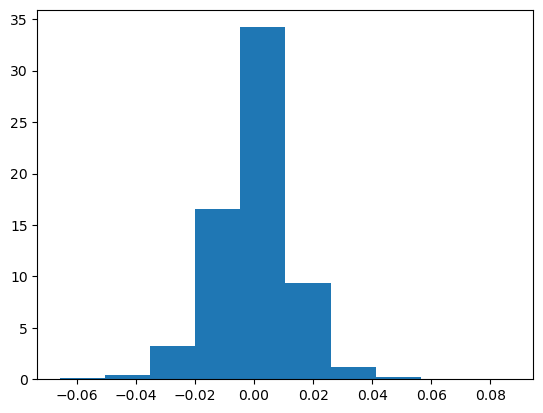

NormaltestResult(statistic=243.49661585730232, pvalue=1.334693930512661e-53)

In [2]:
plt.hist(HSI['returns'], density=True)
plt.show()
stats.normaltest(HSI['returns'])

In [24]:
#Compute the autocorrelations of the squared return.
#It is for computing the inital values for the numerical optimization
return_square = HSI['returns']**2
return_square
rho = statsmodels.tsa.stattools.acf(return_square)
rho

array([1.        , 0.22602461, 0.19943639, 0.1470064 , 0.12529024,
       0.10829988, 0.14414168, 0.12183256, 0.13064461, 0.08886255,
       0.10744391, 0.04880264, 0.08978382, 0.10568981, 0.12467702,
       0.06289156, 0.10095332, 0.0873179 , 0.05936473, 0.06151002,
       0.0812656 , 0.05610102, 0.05316926, 0.05317595, 0.0709979 ,
       0.0668954 , 0.08207204, 0.11113155, 0.05941479, 0.09663601,
       0.05302452, 0.06769099, 0.05844551, 0.09778913, 0.05052536,
       0.06740989])

In [25]:
return_square = HSI['returns']**2
return_square
rho = statsmodels.tsa.stattools.acf(return_square)

# Define the variables
alpha = sp.symbols('alpha')

rho1 = rho[1]
rho2rho1 = rho[2]/rho[1]
# Define the equation
#equation = sp.Eq(k1, x * (1 - (k2 - x)**2 - x*(k2 - x)) / (1 - (k2 - x)**2 - 2*x*(k2 - x)))
equation = sp.Eq(rho1, alpha * (1 - (rho2rho1 - alpha)**2 - alpha*(rho2rho1 - alpha)) / (1 - (rho2rho1 - alpha)**2 - 2*alpha*(rho2rho1 - alpha)))

# Solve for alpha
solutions = sp.solve(equation, alpha)
for x in solutions:
    if x > 0:
        alpha0 = x
        beta0 = rho2rho1 - alpha0

HSI_insample = HSI[HSI['Date']<='2017-12-31']

HSI_outsample = HSI[HSI['Date']>='2018-01-01']


In [26]:
#In this cell, a GARCH(1,1) model is fitted to the in-sample.
#The log-likelihood function and the function for computing hessian are defined.

#log-likelihood function
def garch_log_likelihood(params, returns, p, q):
    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    T = len(returns)
    sigma2 = np.zeros(T + max(p, q))
    epsilon = np.zeros(T + max(p, q))
    
    log_likelihood = 0
    
    sigma2[0: max(p, q)] = np.var(returns)
    epsilon[0: max(p, q)] = returns[0] #assume for the moment the ARMA order is (0,0) with no intercept

    returns = np.concatenate([np.zeros(max(p, q)), returns])

    log_likelihood = 0
    for t in range(max(p, q), T + max(p, q)):
        #print("t: ", t)
        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2

        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]

        sigma2[t] = sigma2_t
        #print("sigma2[t]: ", sigma2[t])
        epsilon[t] = returns[t]
        #print("epsilon[t[: ", epsilon[t])
        #print("")
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(sigma2[t]) + (epsilon[t]**2 / sigma2[t]))

    return -log_likelihood

#gradient of the log-likelihood function
def garch_log_likelihood_grad(params, returns, p, q):
    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    T = len(returns)
    sigma2 = np.zeros(T + max(p, q))
    epsilon = np.zeros(T + max(p, q))
    sigma2[0: max(p, q)] = np.var(returns)
    print('sigma2: ', sigma2)
    returns = np.concatenate([np.zeros(max(p, q)), returns])
    log_likelihood = 0
    dL = np.zeros(1+p+q) # 1st derivative of log-likelihood
    
    
    for t in range(max(p, q), T + max(p, q)):

        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2
            
        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]
        sigma2[t] = sigma2_t
        
        epsilon[t] = returns[t]

    dhdw = np.zeros((1+q+p, T+max(p,q)))

    
    for t in range(max(p, q), T + max(p ,q)):
        
        dhdw[:,t] = np.concatenate([[1], epsilon[t-q:t][::-1]**2, sigma2[t-p:t][::-1]]) + np.sum( dhdw[:, t-p:t][:, ::-1]*beta, axis = 1)
        dL += -0.5 * dhdw[:, t]*(1/sigma2[t] - epsilon[t]**2/sigma2[t]**2)

    return dL

#Hessian matrix of log-likelihood function
def garch_log_likelihood_hess(params, returns, p, q):
    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    T = len(returns)
    sigma2 = np.zeros(T + max(p, q))
    epsilon = np.zeros(T + max(p, q))
    sigma2[0: max(p, q)] = np.var(returns)
    #print('sigma2: ', sigma2)
    returns = np.concatenate([np.zeros(max(p, q)), returns])
    log_likelihood = 0
    dL2 = np.zeros((1+p+q, 1+p+q)) # 2nd derivative of log-likelihood
    
    
    for t in range(max(p, q), T + max(p, q)):

        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2
            
        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]
        sigma2[t] = sigma2_t
        
        epsilon[t] = returns[t]

    dhdw = np.zeros((1+q+p, T+max(p,q)))

    
    for t in range(max(p, q), T + max(p ,q)):
        
        dhdw[:,t] = np.concatenate([[1], epsilon[t-q:t][::-1]**2, sigma2[t-p:t][::-1]]) + np.sum( dhdw[:, t-p:t][:, ::-1]*beta, axis = 1)
        #dL += -0.5 * dhdw[:, t]*(1/sigma2[t] - epsilon[t]**2/sigma2[t]**2)

    d2hdw2 = np.zeros((T+max(p,q), 1+q+p, 1+q+p))
    #print("d2hdw2: ", d2hdw2)
    for t in range(max(p, q), T + max(p ,q)):
        #print("t: ", t)
        #print("1st: ", np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0))
        #print(np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0).shape)
        #print("2nd: ", np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0).T)
        #print(np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0).T.shape)
        #print("3rd: ", np.sum(d2hdw2[t-p:t][::-1]*beta[:, np.newaxis, np.newaxis], axis = 0 ))
        #print(np.sum(d2hdw2[t-p:t][::-1]*beta[:, np.newaxis, np.newaxis], axis = 0 ).shape)
        d2hdw2[t,:,:] = np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0) + \
                        np.append(np.zeros((q+1, p+q+1)), dhdw[:,t-p:t][:, ::-1].T, axis = 0).T + \
                        np.sum(d2hdw2[t-p:t][::-1]*beta[:, np.newaxis, np.newaxis], axis = 0 )
        #print("d2hdw2[t,:,:] ", d2hdw2[t,:,:])
        #print("3rd: ", d2hdw2)
        dL2 += -0.5 * ( (-1/sigma2[t]**2 + 2*epsilon[t]**2/sigma2[t]**3) * dhdw[:,t][:, np.newaxis] @ dhdw[:,t][np.newaxis, :] \
                       +(1/sigma2[t]-epsilon[t]**2/sigma2[t]**2) * d2hdw2[t,:,:]      )
        #print("dL2.shape: ", dL2.shape)
    return dL2

#Choose the order p and q
p = 1
q = 1

#Initial values of the model parameters for minimization of negative of log-likelihood function
initial_params = [0.000003] + [alpha0]*p + [beta0]*q

#Define the bounds of the parameters
bounds = [ (1e-6, None) ] + [(0, 1)]*p + [(0, 1)]*q

#Fit a GARCH(1,1) model to the in-sample by minimizing the negative of log-likelihood
result = minimize(garch_log_likelihood, initial_params, args=(HSI_insample["returns"].values, p, q), method='L-BFGS-B', bounds=bounds)

# Estimated parameters
estimated_params = result.x
omega_est, alpha_est, beta_est = estimated_params
#print("Estimated parameters:", estimated_params)

# Compute standard errors of the estimates
# The standard errors can be approximated from the Hessian matrix
hess = garch_log_likelihood_hess(result.x, HSI_insample["returns"].values, p, q)
Fisher_info = -hess
std_errors = np.sqrt(np.diag(np.linalg.inv(Fisher_info)))

# Print the results
print(f"Estimated omega: {omega_est}, Standard Error: {std_errors[0]}")
print(f"Estimated alpha: {alpha_est}, Standard Error: {std_errors[1]}")
print(f"Estimated beta: {beta_est}, Standard Error: {std_errors[2]}")

print(f"success: {result.success}")
print(f"message: {result.message}")


maximized_loglikelihood = garch_log_likelihood(result.x, HSI_insample["returns"].values, p, q)
print(f"Maximized log-likelihood value: {maximized_loglikelihood}")

Estimated omega: 2.4997146203982606e-06, Standard Error: 9.83001866032699e-07
Estimated alpha: 0.05880489030246077, Standard Error: 0.01172190869135076
Estimated beta: 0.9207482176740402, Standard Error: 0.017708609911228187
success: True
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Maximized log-likelihood value: -5693.505713378558


In [29]:
#In this cell, a function for computing the standardized residuals ( epsilon_t divided by the estimated volatility \head{sigma}_t ) is defined.
#The purpose is for taking a bootstrap sample of the standardized residuals, hence obtaining a bootstrap sample of epsilon_t,
#where epsilon_t is obtained by \eta_t * \sigma_t^{2}. The value-at-risk is the empirical quantile of epsilon_t.

#Alternatively, \eta_t can be simulated from a standard normal distribution. The empirical quantile of epsilon_t is determined by a similar way as that for bootstrap.

#For value-at-risk with high confidence level (99%), the percentage of VaR violation is close to 1% for the bootstrap method,
#while the percentage of violation by assuming eta following the standard normal distribution is close to 2%.
#It reflects the fact that financial returns exhibits heavy tails.


def standardized_residuals_garch(params, returns, p, q):
    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    T = len(returns)
    sigma2 = np.zeros(T + max(p, q))
    epsilon = np.zeros(T + max(p, q))

    eta = np.zeros(T + max(p, q))
    
    sigma2[0: max(p, q)] = np.var(returns)
    epsilon[0: max(p, q)] = returns[0] #assume for the moment the ARMA order is (0,0) with no intercept

    returns = np.concatenate([np.zeros(max(p, q)), returns])

    for t in range(max(p, q), T + max(p, q)):
        #print("t: ", t)
        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2

        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]

        sigma2[t] = sigma2_t
        #print("sigma2[t]: ", sigma2[t])
        epsilon[t] = returns[t]
        eta[t] = epsilon[t]/np.sqrt(sigma2[t])
    return eta, sigma2[-p:], epsilon[-q:]

def forcast_outsample_VaR_bootstrap_garch(params, confidence, eta, insample_last_sigma2, insample_last_epsilon, insample_last_close_price, outsample, p, q):
    #eta is the standardized residual obtained from the insample.
    #insample_last_close_price is the last closing price of the insample.
    #outsample is the dataframe containing the out-of-sample.
    #p and q are garch orders.
    outsample['loss'] = -(outsample['Close']-outsample['Close'].shift(1)) 
    outsample['loss'].iloc[0] = - (outsample['Close'].iloc[0] - insample_last_close_price)

    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    
    T_out = len(outsample)
    if p > q:
        sigma2 = np.concatenate((insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((np.zeros(p-q), insample_last_epsilon, np.zeros(T_out)))
    elif p < q:
        sigma2 = np.concatenate((np.zeros(q-p), insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((insample_last_epsilon, np.zeros(T_out)))
    else:
        sigma2 = np.concatenate((insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((insample_last_epsilon, np.zeros(T_out)))
    qt = np.zeros(max(p,q) + T_out)
    #print(HSI_outsample['returns'])
    returns = np.concatenate((np.zeros(max(p, q)), HSI_outsample['returns']))
    
    for t in range(max(p, q), max(p, q) + T_out):
        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2

        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]

        sigma2[t] = sigma2_t
        #print("sigma2[t]: ", sigma2[t])
        eta_bootstrap = np.random.choice(eta, 5000, replace = True)
        #print('sqrt of sigma2[t]: ', np.sqrt(sigma2[t]))
        
        qt[t] = np.sqrt(sigma2[t]) * np.quantile(eta_bootstrap, confidence, method='inverted_cdf')
        #qt[t] = np.sqrt(sigma2[t]) * scipy.stats.norm.ppf(confidence)
        epsilon[t] = returns[t]
    print('length of outsample: ', len(outsample))
    qt = np.delete(qt, 0)
    print('length of qt: ', len(qt))
    outsample.loc[:,'qt'] = qt
    outsample.loc[:,'VaR'] = outsample['Close'].shift(1)*(1 - np.exp(outsample['qt']))
    outsample.iloc[0,outsample.columns.get_loc('VaR')] = insample_last_close_price*( 1 - np.exp(outsample['qt'].iloc[0]))
    outsample.loc[:,'violation'] = outsample.loc[:, 'loss'] > outsample.loc[:, 'VaR']
    print("number of violation: ", outsample['violation'].sum())
    print("average VaR: ", outsample['VaR'].mean())
    return outsample


eta,insample_last_sigma2, insample_last_epsilon = standardized_residuals_garch(result.x, HSI_insample['returns'].values, 1, 1)



#eta_bootstrap = np.random.choice(eta, 2000, replace = True)
#a = np.quantile(eta_bootstrap, 0.01, method='inverted_cdf')
#a
#plt.hist(eta)
#plt.hist(eta_bootstrap)
HSI_outsample = forcast_outsample_VaR_bootstrap_garch(result.x, 0.01, eta, insample_last_sigma2, insample_last_epsilon, HSI_insample['Close'].iloc[-1], HSI_outsample, 1, 1)

C:\Users\circl\AppData\Local\Temp\ipykernel_464\811575601.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outsample['loss'] = -(outsample['Close']-outsample['Close'].shift(1))
C:\Users\circl\AppData\Local\Temp\ipykernel_464\811575601.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outsample['loss'].iloc[0] = - (outsample['Close'].iloc[0] - insample_last_close_price)


length of outsample:  1626
length of qt:  1626
number of violation:  17
average VaR:  839.555712797038


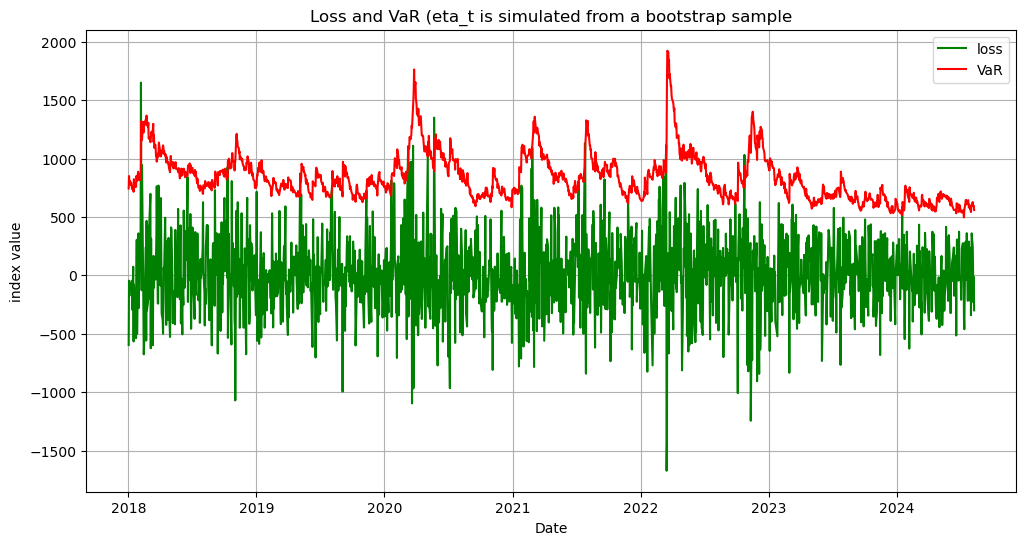

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(HSI_outsample['Date'], HSI_outsample['loss'], label = 'loss', color = 'green')
plt.plot(HSI_outsample['Date'], HSI_outsample['VaR'], label = 'VaR', color = 'red')

#plt.plot(HSI_outsample['loss'], label = 'loss', color = 'green')
#plt.plot(HSI_outsample['VaR'], label = 'VaR', color = 'red')
plt.xlabel('Date')
plt.ylabel('index value')
plt.title('Loss and VaR (eta_t is simulated from a bootstrap sample')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
#Determine the quantile of epsilon_t by assuming that \eta_t follows
def forcast_outsample_VaR_normal_garch(params, confidence, eta, insample_last_sigma2, insample_last_epsilon, insample_last_close_price, outsample, p, q):
    #eta is the standardized residual obtained from the insample.
    #insample_last_close_price is the last closing price of the insample.
    #outsample is the dataframe containing the out-of-sample.
    #p and q are garch orders.
    outsample['loss'] = -(outsample['Close']-outsample['Close'].shift(1)) 
    outsample['loss'].iloc[0] = - (outsample['Close'].iloc[0] - insample_last_close_price)

    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    
    T_out = len(outsample)
    if p > q:
        sigma2 = np.concatenate((insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((np.zeros(p-q), insample_last_epsilon, np.zeros(T_out)))
    elif p < q:
        sigma2 = np.concatenate((np.zeros(q-p), insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((insample_last_epsilon, np.zeros(T_out)))
    else:
        sigma2 = np.concatenate((insample_last_sigma2, np.zeros(T_out)))
        epsilon = np.concatenate((insample_last_epsilon, np.zeros(T_out)))
    qt = np.zeros(max(p,q) + T_out)
    #print(HSI_outsample['returns'])
    returns = np.concatenate((np.zeros(max(p, q)), HSI_outsample['returns']))
    
    for t in range(max(p, q), max(p, q) + T_out):
        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2

        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]

        sigma2[t] = sigma2_t
        #print("sigma2[t]: ", sigma2[t])
        eta_bootstrap = np.random.choice(eta, 5000, replace = True)
        #print('sqrt of sigma2[t]: ', np.sqrt(sigma2[t]))
        
        #qt[t] = np.sqrt(sigma2[t]) * np.quantile(eta_bootstrap, confidence, method='inverted_cdf')
        qt[t] = np.sqrt(sigma2[t]) * scipy.stats.norm.ppf(confidence)
        epsilon[t] = returns[t]
    print('length of outsample: ', len(outsample))
    qt = np.delete(qt, 0)
    print('length of qt: ', len(qt))
    outsample.loc[:,'qt'] = qt
    outsample.loc[:,'VaR'] = outsample['Close'].shift(1)*(1 - np.exp(outsample['qt']))
    outsample.iloc[0,outsample.columns.get_loc('VaR')] = insample_last_close_price*( 1 - np.exp(outsample['qt'].iloc[0]))
    outsample.loc[:,'violation'] = outsample.loc[:, 'loss'] > outsample.loc[:, 'VaR']
    print("number of violation: ", outsample['violation'].sum())
    print("average VaR: ", outsample['VaR'].mean())
    return outsample


eta,insample_last_sigma2, insample_last_epsilon = standardized_residuals_garch(result.x, HSI_insample['returns'].values, 1, 1)



#eta_bootstrap = np.random.choice(eta, 2000, replace = True)
#a = np.quantile(eta_bootstrap, 0.01, method='inverted_cdf')
#a
#plt.hist(eta)
#plt.hist(eta_bootstrap)
HSI_outsample = forcast_outsample_VaR_normal_garch(result.x, 0.01, eta, insample_last_sigma2, insample_last_epsilon, HSI_insample['Close'].iloc[-1], HSI_outsample, 1, 1)

C:\Users\circl\AppData\Local\Temp\ipykernel_464\1126566032.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outsample['loss'] = -(outsample['Close']-outsample['Close'].shift(1))
C:\Users\circl\AppData\Local\Temp\ipykernel_464\1126566032.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outsample['loss'].iloc[0] = - (outsample['Close'].iloc[0] - insample_last_close_price)


length of outsample:  1626
length of qt:  1626
number of violation:  32
average VaR:  704.3797393370153


It can be seen that the bootstrap method has the percentage of loss violating the estimated VaR is close to 1%.
However, the VaR method which assumes eta_t follows a standard normal distribution has the percentage of violation close to 2%.

For the cost, obviously the bootstrap method has a higher cost while the normal (parametric) method has a lower cost.

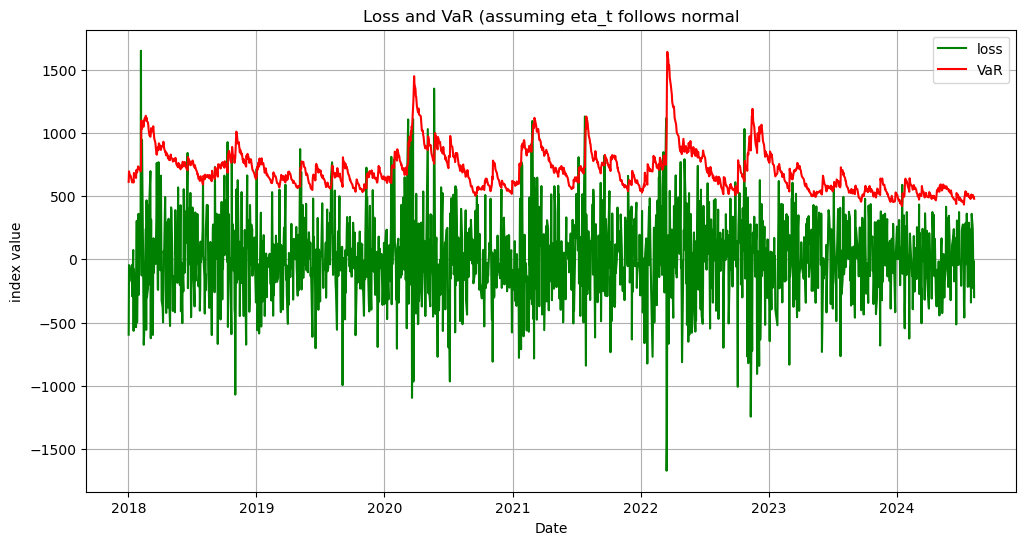

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(HSI_outsample['Date'], HSI_outsample['loss'], label = 'loss', color = 'green')
plt.plot(HSI_outsample['Date'], HSI_outsample['VaR'], label = 'VaR', color = 'red')

#plt.plot(HSI_outsample['loss'], label = 'loss', color = 'green')
#plt.plot(HSI_outsample['VaR'], label = 'VaR', color = 'red')
plt.xlabel('Date')
plt.ylabel('index value')
plt.title('Loss and VaR (assuming eta_t follows normal')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# calculate squared eta, and autocorrelation, not finished

def squared(params, returns, p, q):
    omega = params[0]
    alpha = params[1:p+1]
    beta = params[p+1: p+q+1]
    T = len(returns)
    sigma2 = np.zeros(T + max(p, q))
    epsilon = np.zeros(T + max(p, q))
    
    log_likelihood = 0
    
    sigma2[0: max(p, q)] = np.var(returns)
    epsilon[0: max(p, q)] = returns[0] #assume for the moment the ARMA order is (0,0) with no intercept

    returns = np.concatenate([np.zeros(max(p, q)), returns])

    log_likelihood = 0
    for t in range(max(p, q), T + max(p, q)):
        #print("t: ", t)
        sigma2_t = omega
        for i in range(1, p + 1):
            sigma2_t += alpha[i-1] * epsilon[t-i]**2

        for j in range(1, q + 1):
            sigma2_t += beta[j-1] * sigma2[t-j]

        sigma2[t] = sigma2_t
        #print("sigma2[t]: ", sigma2[t])
        epsilon[t] = returns[t]
        #print("epsilon[t[: ", epsilon[t])
        #print("")
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(sigma2[t]) + (epsilon[t]**2 / sigma2[t]))

    return -log_likelihood



p = 1
q = 1

initial_params = [0.000003] + [0.05]*p + [0.93]*q

bounds = [ (1e-6, None) ] + [(0, 1)]*p + [(0, 1)]*q

#garch_log_likelihood_grad = grad(garch_log_likelihood)

#garch_log_likelihood_hess = hessian(garch_log_likelihood)

returns_array = HSI["returns"].values

log_likelihood = garch_log_likelihood(initial_params, returns_array, p, q)



# minimize the negative of log-likelihood
result = minimize(garch_log_likelihood, initial_params, args=(returns_array, p, q), method='L-BFGS-B', bounds=bounds)

# Estimated parameters
estimated_params = result.x
omega_est, alpha_est, beta_est = estimated_params
print("Estimated parameters:", estimated_params)

# Compute standard errors of the estimates
# The standard errors can be approximated from the Hessian matrix
hessian_inv = result.hess_inv.todense()
std_errors = np.sqrt(np.diag(hessian_inv))
print("Standard errors:", std_errors)

# Print the results
print(f"Estimated omega: {omega_est}, Standard Error: {std_errors[0]}")
print(f"Estimated alpha: {alpha_est}, Standard Error: {std_errors[1]}")
print(f"Estimated beta: {beta_est}, Standard Error: {std_errors[2]}")

print(f"success: {result.success}")
print(f"message: {result.message}")
print(f"jac: {result.jac}")

maximized_loglikelihood = garch_log_likelihood(result.x, returns_array, p, q)
print(f"Maximized log-likelihood value: {maximized_loglikelihood}")